In [13]:
import time
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

import optuna

sys.path.append("/jet/home/azhang19/stat 214/stat-214-lab2-group6/code/modeling")
from preprocessing import to_NCHW, pad_to_384x384, standardize_images
from classification import masked_bce_loss, masked_hinge_loss, l1_reg, ConvHead

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

use_amp = True

In [5]:
# Load and preprocess data
data = np.load("/jet/home/azhang19/stat 214/stat-214-lab2-group6/data/array_data.npz")
unlabeled_images, unlabeled_masks, labeled_images, labeled_masks, labels = data["unlabeled_images"], data["unlabeled_masks"], data["labeled_images"], data["labeled_masks"], data["labels"]

unlabeled_images = pad_to_384x384(to_NCHW(unlabeled_images))
unlabeled_masks = pad_to_384x384(unlabeled_masks)

labeled_images = pad_to_384x384(to_NCHW(labeled_images))
labeled_masks = pad_to_384x384(labeled_masks)
labels = pad_to_384x384(labels)

# Convert to tensors and move to GPU
unlabeled_images = torch.tensor(unlabeled_images, dtype=torch.float32).to(device)  # [161, 8, 384, 384]
unlabeled_masks = torch.tensor(unlabeled_masks, dtype=torch.bool).to(device)    # [161, 384, 384]

labeled_images = torch.tensor(labeled_images, dtype=torch.float32).to(device)      # [3, 8, 384, 384]
labeled_masks = torch.tensor(labeled_masks, dtype=torch.bool).to(device)        # [3, 384, 384]
labels = torch.tensor(labels, dtype=torch.long).to(device)                      # [3, 384, 384]


# Standardize images
unlabeled_images, std_channel, mean_channel = standardize_images(unlabeled_images, unlabeled_masks)
labeled_images, _, _ = standardize_images(labeled_images, labeled_masks, std_channel, mean_channel)

In [6]:
@torch.compile
def train_and_validate(
    train_data, train_labels, val_data, val_labels,
    in_channels, num_layers, kernel_size, hidden_channels,
    epochs, lr, weight_decay, optimizer_class, loss_mix_ratio, l1, class_weight, device
):
    # Create the classifier
    #classifier = nn.Conv2d(in_channels, 1, kernel_size=kernel_size, 
    #                      padding="same", padding_mode="replicate").to(device)
    classifier = ConvHead(in_channels, 1, num_layers, kernel_size, hidden_channels).to(device)
    classifier.train()

    # Instantiate the optimizer
    optimizer = optimizer_class(classifier.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    for epoch in range(epochs):
        classifier.train()
        optimizer.zero_grad(set_to_none=True)
        pred = classifier(train_data)

        bce_loss = masked_bce_loss(pred, train_labels, class_weight=class_weight)
        hinge_loss = masked_hinge_loss(pred, train_labels, class_weight=class_weight)

        loss = loss_mix_ratio * bce_loss + (1 - loss_mix_ratio) * hinge_loss
        # Add L1 regularization
        loss = loss + l1 * l1_reg(classifier)
        loss.backward()
        optimizer.step()

    # Validation
    classifier.eval()
    with torch.inference_mode():
        val_pred = classifier(val_data)
        val_loss, val_acc, val_f1 = masked_hinge_loss(val_pred, val_labels, acc=True, f1=True)

    return val_f1, val_acc

def objective(trial):
    # Suggest hyperparameters with updated API calls
    epochs = trial.suggest_int("epochs", 0, 1000)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "AdamW"])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    hidden_channels = trial.suggest_int("hidden_channels", 1, 64)
    kernel_size = trial.suggest_int("kernel_size", 1, 10)
    loss_mix_ratio = trial.suggest_float("loss_mix_ratio", 0, 1)
    l1 = trial.suggest_float("l1", 1e-5, 5e-1, log=True)

    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])

    feature = labeled_images
    feature, _, _ = standardize_images(feature, labeled_masks)
    
    # Map string to actual optimizer class
    optimizer_class = torch.optim.SGD if optimizer_name == "SGD" else torch.optim.AdamW

    # Cross-validation indices (modify as needed)
    train_val_idx = [0, 1]
    
    # Container for metrics from each fold
    fold_records_f1 = torch.zeros(len(train_val_idx))  # For F1 (objective)
    fold_records_acc = torch.zeros(len(train_val_idx))  # For accuracy (logging)

    # Assuming feature and labels are defined globally (e.g., torch tensors)
    for i in train_val_idx:
        # Leave-one-out style split
        train_idx = [j for j in train_val_idx if j != i]
        val_idx = [i]

        # Get training and validation data
        train_data = feature[train_idx]
        train_labels = labels[train_idx]
        val_data = feature[val_idx]
        val_labels = labels[val_idx]

        # Train and validate, get both F1 and accuracy
        val_f1, val_acc = train_and_validate(
            train_data=train_data,
            train_labels=train_labels,
            val_data=val_data,
            val_labels=val_labels,
            in_channels=feature.shape[1],
            num_layers=num_layers,
            kernel_size=kernel_size,
            hidden_channels=hidden_channels,
            epochs=epochs,
            lr=lr,
            weight_decay=weight_decay,
            optimizer_class=optimizer_class,
            loss_mix_ratio=loss_mix_ratio,
            l1=l1,
            class_weight=class_weight,
            device=device
        )

        fold_records_f1[i] = val_f1
        fold_records_acc[i] = val_acc
    
    avg_f1 = fold_records_f1.mean().item()
    avg_acc = fold_records_acc.mean().item()

    trial.set_user_attr("val_acc", avg_acc)
    #print(f"Trial {trial.number}: F1 = {avg_f1}, Acc = {avg_acc}")
    
    # Return average F1 score across folds
    return avg_f1

In [ ]:
study = optuna.create_study(direction="maximize")

In [ ]:
# Optimize the study by running a number of trials (e.g., 100 trials).
study.optimize(objective, n_trials=9000)

In [ ]:
import pickle
with open("optuna_study_original.pkl", "wb") as f:
    pickle.dump(study, f)

In [8]:
import pickle
with open("optuna_study_original.pkl", "rb") as f:
    study = pickle.load(f)

In [10]:
study.best_params

{'epochs': 505,
 'lr': 0.018935222771886126,
 'weight_decay': 0.00038068503548479643,
 'optimizer': 'AdamW',
 'num_layers': 3,
 'hidden_channels': 54,
 'kernel_size': 1,
 'loss_mix_ratio': 0.3734858582652416,
 'l1': 0.00030670837740724423,
 'class_weight': None}

/var/tmp/ipykernel_85079/1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

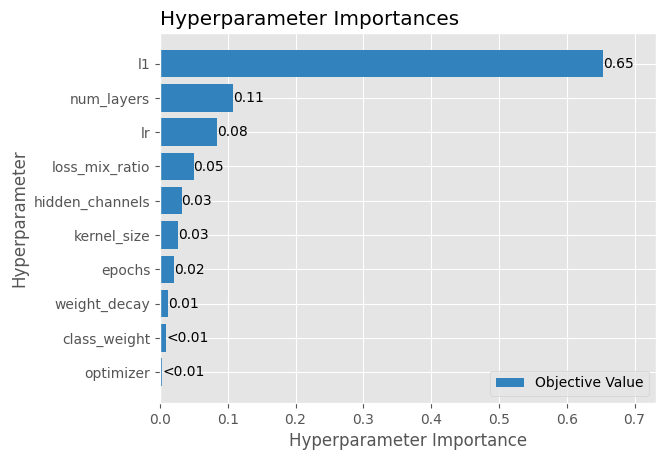

In [12]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [16]:
study.best_params

{'epochs': 505,
 'lr': 0.018935222771886126,
 'weight_decay': 0.00038068503548479643,
 'optimizer': 'AdamW',
 'num_layers': 3,
 'hidden_channels': 54,
 'kernel_size': 1,
 'loss_mix_ratio': 0.3734858582652416,
 'l1': 0.00030670837740724423,
 'class_weight': None}